In [1]:
import os
import sys 
import glob
import dask
import numpy as np
import scipy as sp
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import xarray as xr
import xrft
import xarray_sentinel
import dask.array as da
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from velocity_leakage import S1DopplerLeakage

In [2]:
# importing from one directory  up
sys.path.insert(0, "../" )
from misc import round_to_hour, angular_difference, calculate_distance

In [3]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] 
scenarios

['Carrib_20231104',
 'Azores_20201127',
 'Hawaii_20201106',
 'Barbedos_20201110',
 'Aghulas_20200414',
 'Morroco_20201103',
 'Aghulas_20200121',
 'Aghulas_20191110',
 'Iceland_20231107',
 'Aghulas_20200426',
 'Scotland_20231109',
 'Aghulas_20200402',
 'Aghulas_20190515',
 'Aghulas_20200321']

In [95]:
scenario = 'Scotland_20231109'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")


grid_spacings = []
for i in range(1,21):
    if (8000/4 )% (i*100) == 0:
        grid_spacings.append(int(i))


results = []
grid_spacings = 100*np.array(grid_spacings)

for grid_spacing in grid_spacings:
    observation = S1DopplerLeakage(
        filename=files,
        era5_directory= 'era5_winds/',
        resolution_product=25_000,
        az_mask_cutoff=80_000,
        vx_sat=8000,
        PRF=4,
        grid_spacing=grid_spacing,
        antenna_length=3.2,
        beam_pattern='phased_array',
        _speckle_noise=False,
        era5_smoothing_window= 60, # 15
        # denoise = True,
        )

    # observation.open_data()
    # observation.querry_era5()
    # observation.wdir_from_era5()
    # observation.create_dataset()
    # observation.create_beam_mask()
    # observation.compute_scatt_eqv_backscatter()
    # observation.compute_beam_pattern()
    # observation.compute_leakage_velocity()

    observation.apply()
    net_leakage_subscene = observation.data.V_leakage_pulse_rg_subscene - observation.data.V_leakage_pulse_rg_subscene_inverted
    net_leakage = observation.data.V_leakage_pulse_rg - observation.data.V_leakage_pulse_rg_inverted

    result = np.ravel([np.sqrt(np.mean(net_leakage**2)), np.sqrt(np.mean(net_leakage_subscene**2))])
    results.append(result)


/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/velocity_leakage.py:233: UserWarning: Times can't be serialized faithfully to int64 with requested units 'microseconds since 2023-11-09T18:32:49.587702'. Resolution of 'nanoseconds' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  self.S1_file.to_netcdf(storage_name)
/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/velocity_leakage.py:233: UserWarning: Times can't be serialized faithfully to int64 with requested units 'microseconds since 2023-11-09T18:32:49.587702'. Resolution of 'nanoseconds' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  self.S1_file.to_netcdf(storage_name)
/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analys

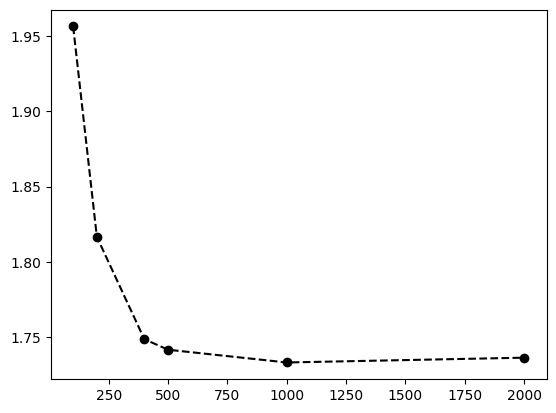

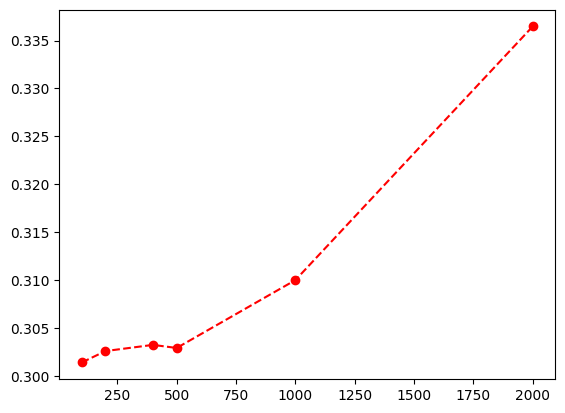

In [ ]:
plt.figure()
plt.plot(grid_spacings, [a[0] for a in results] , '--ok')
plt.figure()
plt.plot(grid_spacings, [a[1] for a in results], '--or')

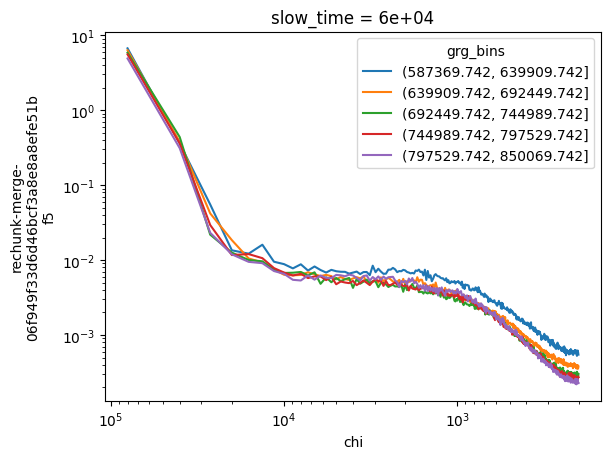

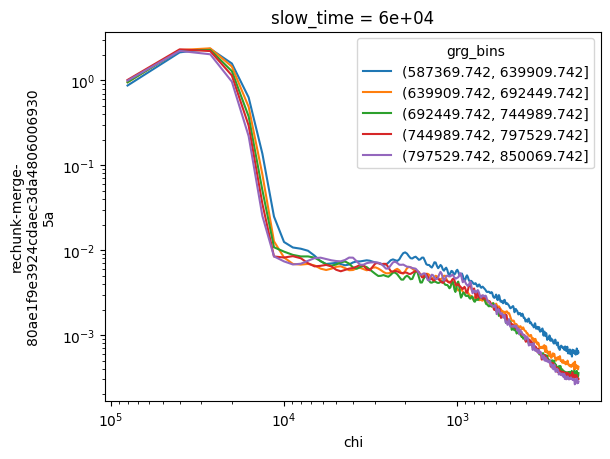

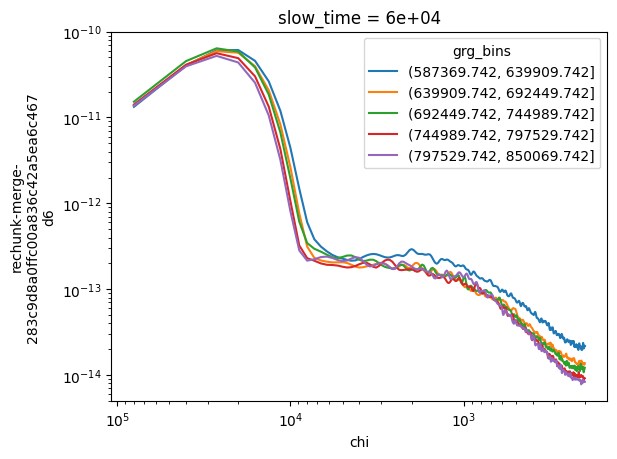

In [103]:
# w_nrcs = observation.data['nrcs_weight']).sum(dim='az_idx', skipna=False).isel(slow_time = 10) 
subset = observation.data.nrcs_weight.isel(slow_time = 10) * observation.data.dop_geom
subset_beam = observation.data.beam
weight_nrcs = observation.data['nrcs_weight'].sum(dim='az_idx', skipna=False).isel(slow_time = 10) 
weight_beam = observation.data['beam'].sum(dim='az_idx', skipna=False)
weight_beam_nrcs = (observation.data['beam'] * observation.data['nrcs_weight']).sum(dim='az_idx', skipna=False).isel(slow_time = 10) 

PSD = xrft.power_spectrum(subset/weight_nrcs, window = 'hann', scaling='spectrum', dim = 'az_idx')#
PSD_beam = xrft.power_spectrum(subset_beam/weight_beam, window = 'hann', scaling='spectrum', dim = 'az_idx')#
# PSD_beam = xrft.power_spectrum(subset_beam, window = 'hann', scaling='spectrum', dim = 'az_idx')#
PSD_combined = xrft.power_spectrum(subset*subset_beam/weight_beam_nrcs, window = 'hann', scaling='spectrum', dim = 'az_idx')#
PSD_combined2 = xrft.power_spectrum(subset/weight_nrcs*(subset_beam/weight_beam)**2, window = 'hann', scaling='spectrum', dim = 'az_idx')#

def PSD_slices(PSD, dim2 = 'grg'):
    n_slices = 6
    PSD_single = PSD.sel({PSD.dims[0]: slice(0, 1)})*2

    # replace dimension
    PSD_single = PSD_single.assign_coords({"chi": 1/PSD_single[PSD_single.dims[0]]})

    PSD_single = PSD_single.swap_dims({PSD_single.dims[0]:'chi'})

    grg_bins = np.linspace(PSD_single[dim2].min(), PSD_single[dim2].max(), n_slices)

    PSD_single_grouped = PSD_single.groupby_bins(dim2, grg_bins).mean(dim = dim2)

    plt.figure()
    _ = PSD_single_grouped.sel(chi = slice(100E3, 0)).plot.line(x=PSD_single.dims[0])
    plt.xscale("log"); plt.yscale("log")
    plt.gca().invert_xaxis()
    return

PSD_slices(PSD)
# PSD_slices(PSD_beam)
PSD_slices(PSD_combined)
PSD_slices(PSD_combined2)
# PSD_slices(PSD_combined*PSD_beam)
# PSD_slices((PSD_beam**2)/PSD_beam)

# sum(PSD_combined * weight)

In [98]:

# import copy


# coarsening_factors = []
# for i in range(1,21):
#     if (observation.vx_sat/observation.PRF )% (i*100) == 0:
#         coarsening_factors.append(int(i))

# coarsening_factors

# results = []
# for coarsening_factor in tqdm(coarsening_factors):

#     # find indexes of S1 scene that were cropped (outside full beam pattern)
#     idx_start = observation.idx_az[0][observation.az_mask_pixels_cutoff]
#     idx_end = observation.idx_az[-1][observation.az_mask_pixels_cutoff]

#     # create placeholder S1 data (pre-cropped)
#     new_nrcs = np.nan * np.ones_like(observation.S1_file.NRCS_VV)
#     new_inc = np.nan * np.ones_like(observation.S1_file.NRCS_VV)

#     # add speckle noise assuming a single look
#     if observation._speckle_noise:
#         noise_multiplier = observation.speckle_noise(observation.data.nrcs_scat.shape, random_state = observation.random_state)
#     elif not observation._speckle_noise:
#         noise_multiplier = 1

#     single_look_nrcs = noise_multiplier * observation.data.nrcs_scat

#     # interpolate estimated scatterometer data back to S1 grid size
#     slow_time_upsamp = np.linspace(observation.data.slow_time[0], observation.data.slow_time[-1], idx_end - idx_start) 
#     nrcs_scat_upsamp = single_look_nrcs.T.interp(slow_time = slow_time_upsamp)
#     inc_scat_upsamp = observation.data.inc_scatt_eqv_cube.mean(dim='az_idx').T.interp(slow_time = slow_time_upsamp)

#     # apply cropping 
#     new_nrcs[idx_start: idx_end, :] = nrcs_scat_upsamp
#     new_inc[idx_start: idx_end, :] = inc_scat_upsamp

#     self_copy = copy.deepcopy(observation)
#     self_copy.S1_file['NRCS_VV'] = (['azimuth_time', 'ground_range'], new_nrcs)
#     self_copy.S1_file['inc'] = (['azimuth_time', 'ground_range'], new_inc)

#     if type(coarsening_factor) == int:
#         boundary_option = 'trim'
#         self_copy.S1_file = self_copy.S1_file.coarsen({'azimuth_time': coarsening_factor, 'ground_range':coarsening_factor}, boundary = boundary_option).mean()
#         self_copy.wdir_wrt_sensor = self_copy.wdir_wrt_sensor.coarsen({'azimuth_time': coarsening_factor, 'ground_range':coarsening_factor}, boundary = boundary_option).median()

#         self_copy.grid_spacing = observation.grid_spacing * coarsening_factor
#         self_copy.__post_init__()

#     # define names of variables to consider and return
#     data_to_return = ['doppler_pulse_rg', 'doppler_pulse_rg_subscene', 'V_leakage_pulse_rg', 'V_leakage_pulse_rg_subscene', 'nrcs_scat', 'nrcs_scat_subscene']
#     data_to_return_new_names = [name + '_inverted' for name in data_to_return[:-2]] + ['nrcs_scat_w_noise', 'nrcs_scat_subscene_w_noise']

#     # repeat the  previous chain of computations NOTE this could be done more efficiently
#     self_copy.create_dataset()
#     self_copy.create_beam_mask()
#     self_copy.compute_scatt_eqv_backscatter()
#     self_copy.compute_beam_pattern()
#     self_copy.compute_leakage_velocity()



#     # net_leakage_subscene = observation.data.V_leakage_pulse_rg_subscene - self_copy.data.V_leakage_pulse_rg_subscene
#     # net_leakage = observation.data.V_leakage_pulse_rg - self_copy.data.V_leakage_pulse_rg
#     observation.data['V_leakage_pulse_rg_subscene'], observation.data['V_leakage_pulse_rg'],self_copy.data['V_leakage_pulse_rg_subscene'], self_copy.data['V_leakage_pulse_rg'] = dask.compute([
#         observation.data.V_leakage_pulse_rg_subscene,
#         observation.data.V_leakage_pulse_rg,
#         self_copy.data.V_leakage_pulse_rg_subscene,
#         self_copy.data.V_leakage_pulse_rg])[0]

#     net_leakage_subscene = observation.data.V_leakage_pulse_rg_subscene - self_copy.data.V_leakage_pulse_rg_subscene
#     net_leakage = observation.data.V_leakage_pulse_rg - self_copy.data.V_leakage_pulse_rg

#     result = np.ravel([np.sqrt(np.mean(net_leakage**2)), np.sqrt(np.mean(net_leakage_subscene**2))])
#     results.append(result)
